# Tehtävä 5: koneoppimisen ja syväoppimisen toteutus 

- Tässä dokumentissa keskitytään edellisten tulosten optimointiin ja tarkempaan analyysiin.

In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import plotly.express as px
# from pandas_profiling import ProfileReport
# from sklearn.impute import KNNImputer
import seaborn as sns
df = pd.read_csv("./data/base.csv", low_memory=False)


pd.options.display.max_columns = None
#pd.set_option('display.float_format', str)
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

In [121]:
# Muutetaan päivänmäärä pelkästään vuodeksi, koska scalerit eivät toimi datatimen kanssa
df["installation_date"] = pd.to_datetime(df['installation_date']).dt.year

In [122]:
# Siivotaan datasto pois rivit missä hinta/DC suhde on alle 1000 tai yli 50000
df = df[(df["total_installed_price"] / df["system_size_DC"] >= 1000) & (df["total_installed_price"] / df["system_size_DC"] <= 50000)]

### Luetaan aikaisemmin käsitelty dataframe ja muodostetaan siitä erilaiset versiot

In [123]:
# Otetaan mukaan residential-järjestelmät, missä ei ole akkua
res = df[(df['residential'] == 1) & (df['battery'] == 0)]
# Otetaan mukaan residential-järjestelmät, missä on akku
res_bat = df[(df['residential'] == 1) & (df['battery'] == 1)]

# Otetaan mukaan non_residential-järjestelmät, missä ei ole akkua
non_res = df[(df['residential'] == 0) & (df['battery'] == 0)]
# Otetaan mukaan non_residential-järjestelmät, missä on akku
non_res_bat = df[(df['residential'] == 0) & (df['battery'] == 1)]


res = res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
res_bat = res_bat.drop(columns=['battery', 'residential'])
non_res = non_res.drop(columns=['battery', 'battery_rated_capacity_kW', 'residential'])
non_res_bat = non_res_bat.drop(columns=['battery', 'residential'])

### Tehtävään valitut algoritmit

-Regressiomallit kuvaavat yhteyttä syötemuuttujien ja valitun tarkasteltavan muuttujan välillä. Regressiomenetelmät kuten lineaariregressio  tuottavat vastaukseksi lukuarvon, jonka ei tarvitse olla kokonaisluku. Tästä syystä se sopii hyvin tässä projektissa esimerkiksi hinnan ennustamiseen. Kaikki tarkasteluun otetut algoritmit ovat regressiomalleja. Tavoitteena on ajaa testit valituille malleille ja löytää niistä lähtökohtaisesti 3 parasta mallia, ja tämän jälkeen hienosäätää valitut mallit mahdollisimman tehokkaiksi.

In [124]:
from math import sqrt
from pandas import MultiIndex, Int16Dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import Pool, CatBoostRegressor

In [125]:
random_state = 42
models = {"RandomForest": RandomForestRegressor(random_state=random_state),
            "XGBoost": XGBRegressor(seed = random_state),
            "CatBoost": CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)
            }

## Algoritmien vertailu

Rakennetaan funktio, jolle voi antaa parametrina eri datasettejä ja eri normalisointi funktiota. Funktio palauttaa dataframen missä on jokaiselle algoritmille laskettu arvot eri metriikoita käyttäen ja samalla piirretään kuvaaja, missä näkyy mielestämme mielenkiintoisin sarake eli 
ennustuksen Mean absolute error.

### Algoritmien paremmuuden määrittämiseen käytettiin seuraavia metriikoita: 

- RMSE = Root Mean Square Error. Keskineliövirheen neliöjuuri antaa normalisoidun etäisyyden ennustettujen arvojen vektorin ja pohjatotuutena olevan vektorin välillä. 
- R2 = R squared. R2-luku kertoo kuinka hyvin malli sovittuu regressiomalleissa opetusaineistoon. R2-luku kertoo kuinka suuren osuuden mallin muuttujat voivat selittää pohjatotuudesta.
- MAE = Mean absolute error.  Keskimääräinen absoluuttinen virhe antaa numeerisen arvon, joka kertoo kuinka paljon algoritmin tekemä arvio keskimäärin erosi pohjatotuudesta. 

In [116]:
def evaluate_models(df,scaler,models,features="no"):    
    random_state = 42

    tulos = pd.DataFrame

    # Jaetaan data treeni ja testi settiin 

    y = df["total_installed_price"]
    X = df.drop(columns="total_installed_price")

    features = X.columns

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

    tulos = pd.DataFrame(columns=["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"])
    
    # Skaalataan data funktio kutsussa käytetyllä skaalaajalla

    if scaler != "None":

        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

        


    # Sovitetaan data mallille ja  määritellään RMSE, R2 ja MAE testi- ja treeni-seteille ja tallennetaan ne dataframeen

    for name, model in models.items():
        

        model.fit(X_train,y_train)

        RMSE_test = sqrt(mean_squared_error(y_test, model.predict(X_test)))
        RMSE_train = sqrt(mean_squared_error(y_train, model.predict(X_train)))
        r2_test = r2_score(y_test, model.predict(X_test))
        r2_train = r2_score(y_train, model.predict(X_train))
        MAE_test = mean_absolute_error(y_test, model.predict(X_test))
        MAE_train = mean_absolute_error(y_train, model.predict(X_train))

        tulos.loc[len(tulos)] = [name,scaler,RMSE_train,RMSE_test,r2_train,r2_test,MAE_train,MAE_test]

    
        # Tulostetaan kuvaajina kolumnien tärkeys
        if features == "yes":
            sorted_feat = model.feature_importances_.argsort()
            plt.barh(df.columuns[sorted_feat], model.feature_importances_[sorted_feat])
            plt.title(f"{name} Feature Importance")
            plt.show()


        
    # plt.figure(figsize=(10,5))
    # plt.subplot(1,2,1)
    # plt.title("Mean absolute error testset")
    # sns.barplot(data=tulos,x ="Model", y="MAE test")
    # plt.xticks(rotation=45,ha="right")
    # plt.subplot(1,2,2)
    # plt.title("R2 score testset")
    # sns.barplot(data=tulos,x ="Model", y="R2 test")
    # plt.xticks(rotation=45,ha="right")

    # plt.show()
        
    
    return tulos

In [119]:
# Funktio, millä voidaan siivota poikkeamat pois datasetistä käyttäen IQR-menetelmää

def exception_handling(df):

    #features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']

    features = ['system_size_DC', 'total_installed_price',        
            'inverter_loading_ratio', 'module_quantity','module_efficiency',
            'inverter_quantity', 'inverter_total_capacity']

    for col in features:

            alaraja, ylaraja = np.percentile(a=df[col], q=[25,75])
            iqr = ylaraja - alaraja
            print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

            # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

            alaraja_iqr = alaraja - 1.5*iqr
            ylaraja_iqr = ylaraja + 1.5*iqr

            df_clean = df[(df[col] > alaraja_iqr) & (df[col] < ylaraja_iqr)]
            
    print("\nKeskihinta = ",df_clean["total_installed_price"].mean())
    print("Alkuperäisen DataFramen koko = ",df.shape)
    print("Siivotun DataFramen koko = ",df_clean.shape)
    return df_clean


testi = exception_handling(res_bat)

system_size_DC Alaraja = 6.1 Yläraja = 9.28 IQR = 3.1799999999999997
total_installed_price Alaraja = 28243.0 Yläraja = 43897.8 IQR = 15654.800000000003
inverter_loading_ratio Alaraja = 0.913865546218487 Yläraja = 1.1656381302521 IQR = 0.2517725840336129
module_quantity Alaraja = 20.0 Yläraja = 30.0 IQR = 10.0
module_efficiency Alaraja = 0.180379746835443 Yläraja = 0.200157214393851 IQR = 0.019777467558408007
inverter_quantity Alaraja = 1.0 Yläraja = 2.0 IQR = 1.0
inverter_total_capacity Alaraja = 6.599999999999994 Yläraja = 7.616000000000005 IQR = 1.0160000000000107

Keskihinta =  35520.07047573273
Alkuperäisen DataFramen koko =  (6057, 28)
Siivotun DataFramen koko =  (4162, 28)


In [ ]:
# Funktio jolla piirtää kuvaajat dataseteistä

def draw_graph(df):

    df = df.sort_values("Model")

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title("Mean absolute error testset")
    sns.barplot(data=df,x ="Model", y="MAE test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.subplot(1,2,2)
    plt.title("R2 score testset")
    sns.barplot(data=df,x ="Model", y="R2 test",hue="Scaler")
    plt.xticks(rotation=45,ha="right")
    plt.legend(loc='lower right')
    plt.show()

In [126]:
res_bat_clean = res_bat.copy()

# features = ['system_size_DC', 'total_installed_price',        
#         'inverter_loading_ratio', 'module_quantity','module_efficiency',
#         'inverter_quantity', 'inverter_total_capacity']

features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']



for col in features:

        alaraja, ylaraja = np.percentile(a=res_bat_clean[col], q=[25,75])
        iqr = ylaraja - alaraja
        print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

        # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

        alaraja_iqr = alaraja - 1.5*iqr
        ylaraja_iqr = ylaraja + 1.5*iqr

        res_bat_clean = res_bat_clean[(res_bat_clean[col] > alaraja_iqr) & (res_bat_clean[col] < ylaraja_iqr)]

print("\nKeskihinta = ",res_bat_clean["total_installed_price"].mean())
print("Alkuperäisen DataFramen koko = ",res_bat.shape)
print("Siivotun DataFramen koko = ",res_bat_clean.shape)

system_size_DC Alaraja = 6.1 Yläraja = 9.28 IQR = 3.1799999999999997
total_installed_price Alaraja = 27765.5 Yläraja = 42405.0 IQR = 14639.5
inverter_loading_ratio Alaraja = 0.909926470588235 Yläraja = 1.16279069767442 IQR = 0.25286422708618506
module_quantity Alaraja = 19.0 Yläraja = 28.0 IQR = 9.0
module_efficiency Alaraja = 0.180379746835443 Yläraja = 0.200157214393851 IQR = 0.019777467558408007
inverter_total_capacity Alaraja = 6.135000000000002 Yläraja = 7.616000000000001 IQR = 1.4809999999999999

Keskihinta =  34552.197284873124
Alkuperäisen DataFramen koko =  (6057, 28)
Siivotun DataFramen koko =  (4416, 28)


In [94]:
# Luodaan tyhjä dataframe mihin tallentaa kaikki tulokset

lopputulos = pd.DataFrame(columns=["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"])

In [ ]:
# Alustetaan tarvittavia listoja
result_columns = ["Model","Scaler","RMSE train","RMSE test","R2 train","R2 test","MAE train","MAE test"] 
scalers = ["None", StandardScaler(), RobustScaler(), MinMaxScaler()]

## Akulliset residential kohteet
- Tässä setissä hinnan keskiarvo = 34546.66435248511
- Dataframen koko = 4416

In [ ]:
# Testataan onko tässä järkeä

lopputulos_res_bat = pd.DataFrame(columns=result_columns)

# Siivotaan poikkeukset
res_bat_clean = exception_handling(res_bat)

for scaler in scalers:
    data = evaluate_models(res_bat_clean,scaler,models)
    lopputulos_res_bat.append(data)

# Piirretään kuvaaja
draw_graph(lopputulos_res_bat)  

lopputulos_res_bat = lopputulos_res_bat.sort_values(["Model","R2 test","MAE test"])
lopputulos_res_bat

In [ ]:
lopputulos_res_bat.describe()

In [ ]:
draw_graph(lopputulos_res_bat)


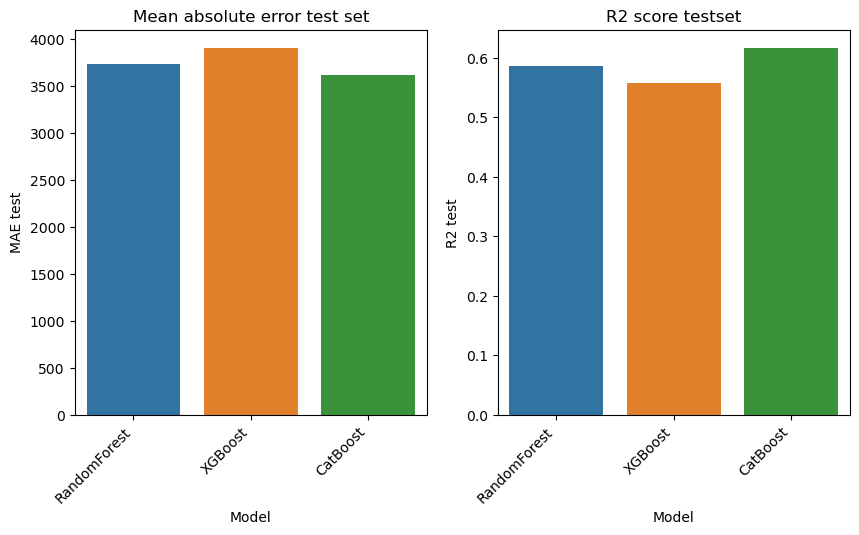

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,None,2379.412240,5950.450306,0.935343,0.585808,1497.536379,3735.962969
1,XGBoost,None,1860.343560,6153.734606,0.960476,0.557024,1214.049902,3904.582354
2,CatBoost,None,3366.071771,5729.322910,0.870603,0.616020,2316.333736,3623.078517


In [95]:
res_bat_clean = exception_handling(res_bat)

data = evaluate_models(res_bat_clean,"None",models)

lopputulos = data

data

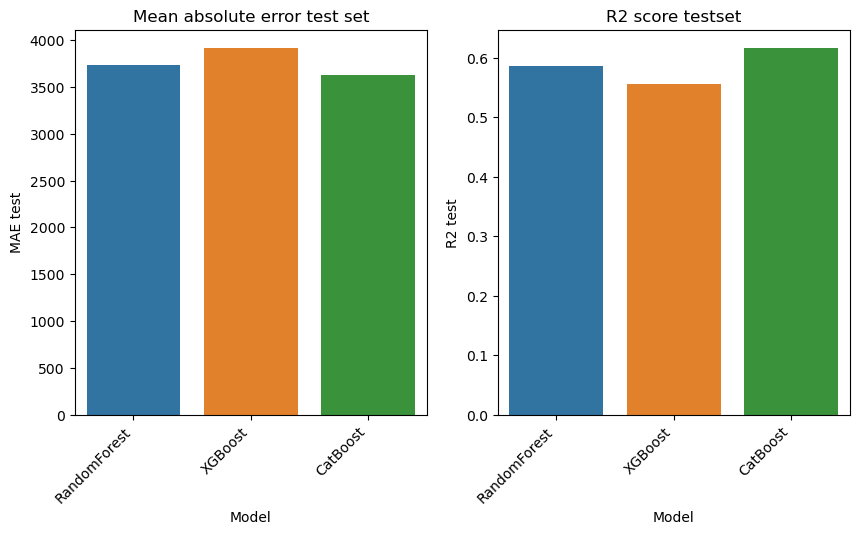

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,StandardScaler(),2378.053129,5948.509634,0.935417,0.586078,1497.145237,3734.741520
1,XGBoost,StandardScaler(),1747.341461,6160.361917,0.965132,0.556070,1158.215204,3914.121899
2,CatBoost,StandardScaler(),3366.071771,5729.802830,0.870603,0.615955,2316.333736,3623.779141


In [96]:
data = evaluate_models(res_bat_clean,StandardScaler(),models)

lopputulos = lopputulos.append(data)

data

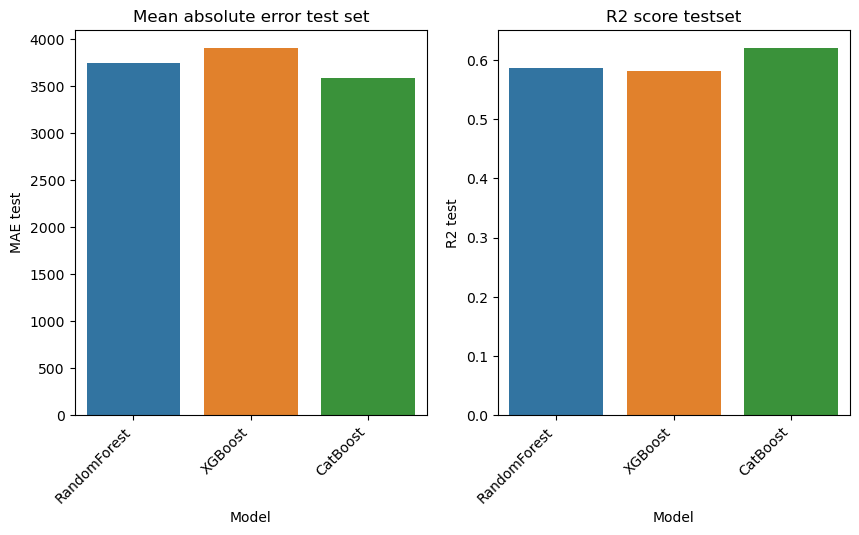

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,RobustScaler(),2378.844856,5949.806536,0.935374,0.585897,1497.447730,3740.889977
1,XGBoost,RobustScaler(),1759.978616,5980.392597,0.964625,0.581629,1182.430543,3902.874649
2,CatBoost,RobustScaler(),3328.831458,5697.540973,0.873451,0.620268,2289.284807,3589.866451


In [97]:
data = evaluate_models(res_bat_clean,RobustScaler(),models)

lopputulos = lopputulos.append(data)

data

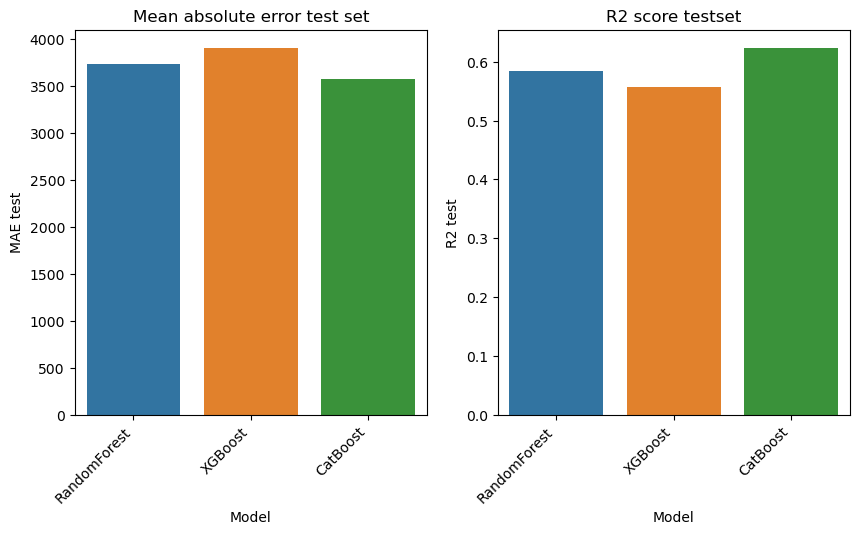

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,MinMaxScaler(),2382.343353,5955.515629,0.935184,0.585102,1499.298038,3741.150983
1,XGBoost,MinMaxScaler(),1860.343560,6154.209725,0.960476,0.556956,1214.049902,3907.206791
2,CatBoost,MinMaxScaler(),3310.607391,5676.138437,0.874833,0.623115,2284.151072,3581.035149


In [98]:
data = evaluate_models(res_bat_clean,MinMaxScaler(),models)

lopputulos = lopputulos.append(data)

data

In [99]:
lopputulos

,Model,Scaler,RMSE train,RMSE test,R2 train,R2 test,MAE train,MAE test
0,RandomForest,None,2379.412240,5950.450306,0.935343,0.585808,1497.536379,3735.962969
1,XGBoost,None,1860.343560,6153.734606,0.960476,0.557024,1214.049902,3904.582354
2,CatBoost,None,3366.071771,5729.322910,0.870603,0.616020,2316.333736,3623.078517
0,RandomForest,StandardScaler(),2378.053129,5948.509634,0.935417,0.586078,1497.145237,3734.741520
1,XGBoost,StandardScaler(),1747.341461,6160.361917,0.965132,0.556070,1158.215204,3914.121899
2,CatBoost,StandardScaler(),3366.071771,5729.802830,0.870603,0.615955,2316.333736,3623.779141
0,RandomForest,RobustScaler(),2378.844856,5949.806536,0.935374,0.585897,1497.447730,3740.889977
1,XGBoost,RobustScaler(),1759.978616,5980.392597,0.964625,0.581629,1182.430543,3902.874649
2,CatBoost,RobustScaler(),3328.831458,5697.540973,0.873451,0.620268,2289.284807,3589.866451
0,RandomForest,MinMaxScaler(),2382.343353,5955.515629,0.935184,0.585102,1499.298038,3741.150983


In [100]:
lopputulos.describe().T

,count,mean,std,min,25%,50%,75%,max
RMSE train,12.0,2509.853597,662.874099,1747.341461,1860.343560,2379.128548,3315.163407,3366.071771
RMSE test,12.0,5923.815508,179.927128,5676.138437,5729.682850,5950.128421,6023.728099,6160.361917
R2 train,12.0,0.923460,0.039529,0.870603,0.874487,0.935358,0.960476,0.965132
R2 test,12.0,0.589160,0.024917,0.556070,0.575478,0.585852,0.615971,0.623115
MAE train,12.0,1663.856357,488.941475,1158.215204,1214.049902,1497.492054,2285.434506,2316.333736
MAE test,12.0,3749.940867,129.944076,3581.035149,3623.603985,3738.426473,3903.301575,3914.121899


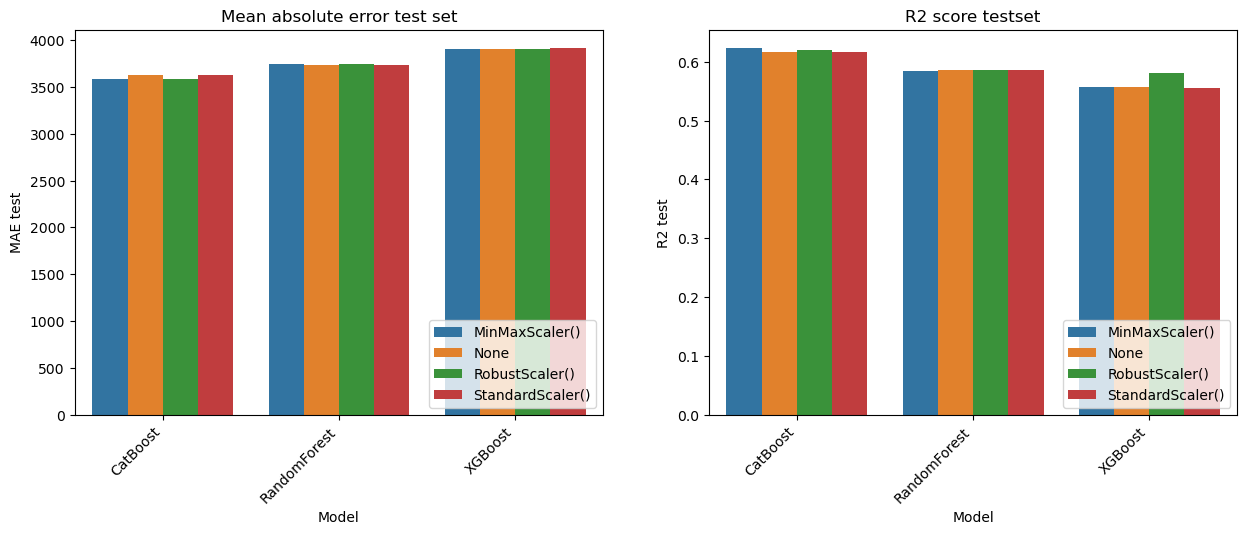

In [101]:



lopputulos = lopputulos.sort_values("Model")


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Mean absolute error testset")
sns.barplot(data=lopputulos,x ="Model", y="MAE test",hue="Scaler")
plt.xticks(rotation=45,ha="right")
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.title("R2 score testset")
sns.barplot(data=lopputulos,x ="Model", y="R2 test",hue="Scaler")
plt.xticks(rotation=45,ha="right")
plt.legend(loc='lower right')
plt.show()

### Mietteitä ja huomioita akullisista residential systeemeistä

- Poikkeamien poistaminen laski MAE:n arvoa noin 2000:lla ja R2 scoressa oli myös pieniä parannuksia
- MAE heitti parhaimmillaan 3800 pohjatotuudesta, mikä keskiarvoon nähden ei ole huono, mutta ei myöskään loistava
- Kaikkien algoitmien R2 train oli huomattavasti parempi, mitä vastaava R2 test. Tästä voisi päätellä, että mallit ovat reippaasti ylioppineita

### Käytössä olevien algoritmien määrän vähentäminen

Esikarsinnan tuloksena valikoitui 3 algoritmia: RandomForest, CatBoost, ja XGBoost Regressor. Kaikki näistä ovat päätöspuihin perustuvia algoritmeja. 
 
Päätöspuiden avulla pyritään kuvaamaan dataa puurakenteen avulla. Oksat kuvaavat datapisteestä tehtyjä havaintoja ja solmut johtopäätöksiä datapisteen siitä muuttujasta, jota päätöspuun avulla halutaan ennakoida. Gradienttitehostetut päätöspuut yhdistävät useita päätöspuita ennusteen tekemiseksi. Päätöspuut ovat tehokkaita käytettynä koneoppimisessa ja niitä voidaan käyttää monimutkaisiin aineistoihin ja ne sopivat myös regressiotehtäviin ,joten ne soveltuvat hyvin tähän projektiin.
 
Oikein säädettynä gradienttitehostetuiden puiden pitäisi suoriutua paremmin kuin satunnaismetsä(random forest tree). Tehostetut puut luovat yhden puun kerrallaan ja jokainen uusi puu yrittää parantaa edellisen puun suoritusta. Satunnaismetsä kouluttaa jokaisen puun itsenäisenä yksikkönä satunnaisella näytteellä datasta. Satunnaisuuden vuoksi mallissa ei tapahdu niin helposti ylioppimista.



### Hyperparametrien optimointi
Tehdään hyperparametrien optimointi käyttäen sklearnin RandomizedSearchCV algortimia.

# --------------------------ÄLÄ AJA SEURAAVAA KOLMEA-------------------------------------

In [128]:
# from sklearn.model_selection import RandomizedSearchCV
# random_state= 42

# y = res_bat_clean["total_installed_price"]
# X = res_bat_clean.drop(columns="total_installed_price")

# features = X.columns

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 


# #Ensimmäisenä RandomForestRegressor

# # Määritellään kokeiltavat parametrit
# param_grid = [
#                 {'bootstrap': [True, False],
#                 'max_depth': [3,6,5,7,9,10, 20, 30, None],
#                 'max_features': ['auto', 'sqrt'],
#                 'min_samples_leaf': [1, 2, 4],
#                 'min_samples_split': [2, 5, 10],
#                 'n_estimators': [800, 1000, 1200, 1400, 1600, 1800, 2000]}
#                 ]

# model = RandomForestRegressor(random_state=random_state)

# grid = RandomizedSearchCV(
#         model,
#         param_grid,
#         n_iter=25, scoring='neg_mean_squared_error', verbose=1)


# grid.fit(X_train,y_train)

# #grid.best_estimator_

# grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [108]:
# y = res_clean["total_installed_price"]
# X = res_clean.drop(columns="total_installed_price")

# features = X.columns

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

# param_grid = [
#                 {'depth':[3,1,2,6,4,5,7,8,9,10],
#                 'iterations':[250,100,500,1000],
#                 'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#                 'l2_leaf_reg':[3,1,5,10,100],
#                 'border_count':[32,5,10,20,50,100,200],
#                 'subsample':[0.5, 0.7, 1.0]
                
#                 }
#                 ]

# model = CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False)

# grid = RandomizedSearchCV(
#         model,
#         param_grid,
#         n_iter=25, scoring='neg_mean_squared_error', verbose=1)


# grid.fit(X_train,y_train)

# grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'subsample': 0.5,
 'learning_rate': 0.3,
 'l2_leaf_reg': 10,
 'iterations': 1000,
 'depth': 10,
 'border_count': 200}

In [130]:
# y = res_clean["total_installed_price"]
# X = res_clean.drop(columns="total_installed_price")

# features = X.columns

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 



# param_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


# model = XGBRegressor(seed=random_state)

# grid = RandomizedSearchCV(
#         model,
#         param_grid,
#         n_iter=25, scoring='neg_mean_squared_error', verbose=1)


# grid.fit(X_train,y_train)

# grid.best_params_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


{'subsample': 0.8999999999999999,
 'n_estimators': 2000,
 'max_depth': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 0.8999999999999999}

#### optimointien tulokset:

- RandomForest: dataset = res_bat_clean
    - {'n_estimators': 1800,
    - 'min_samples_split': 2,
    - 'min_samples_leaf': 2,
    - 'max_features': 'sqrt',
    - 'max_depth': 20,
    - 'bootstrap': False}

- CatBoostRegressor: dataset = res_clean
    - {'subsample': 0.5,
    - 'learning_rate': 0.3,
    - 'l2_leaf_reg': 10,
    - 'iterations': 1000,
    - 'depth': 10,
    - 'border_count': 200}

- XGBRegressor: dataset = res_clean
    - {'subsample': 0.8999999999999999,
    - 'n_estimators': 2000,
    - 'max_depth': 6,
    - 'learning_rate': 0.1,
    - 'colsample_bytree': 0.7,
    - 'colsample_bylevel': 0.8999999999999999}


Otetaan RandomizedSearchCV algoritmin ehdotukset käyttöön ja koitetaan ajaa vielä yksi testi samalla datasetillä

In [ ]:
models_tuned = {  "RandomForest": RandomForestRegressor(n_estimators=1800,max_features='sqrt',max_depth=20,min_samples_leaf=2,min_samples_split=2,bootstrap=False, random_state=random_state),
            "CatBoost":CatBoostRegressor(random_seed = random_state, loss_function='RMSE', eval_metric ="MAE", verbose=False,subsample=0.5,learning_rate=0.3,l2_leaf_reg=10,iterations=1000,depth=10,border_count=200),
            "XGBoost Regressor": XGBRegressor(subsample=0.8999999999999999,n_estimators=2000, max_depth=6,learning_rate=0.1,colsample_bytree= 0.7,colsample_bylevel=0.8999999999999999,seed = random_state)
            }




In [ ]:
#evaluate_models(res_bat_clean,StandardScaler(),models)

# Testataan onko tässä järkeä

lopputulos_res_bat_optimized = pd.DataFrame(columns=result_columns)

for scaler in scalers:
    data = evaluate_models(res_bat_clean,scaler,models_tuned)
    lopputulos_res_bat_optimized.append(data)

In [ ]:
lopputulos_res_bat_optimized.describe().T

In [ ]:
draw_graph(lopputulos_res_bat_optimized)

- Käyttämällä RandomizedSearchCV arvoja MAE testin arvot laskivat vielä noin 200-300.
- R2 train arvo tippu XGBoost regressorilla, mutta nousi Gradient Tree:llä. Randomforestilla pysyi melko samana
- R2 test arvot nousivat jokaisella algoritmillä, mikä on hyvä asia. Tosin ne vieläkin ovat 60% kieppeillä

## Non_residential kohteita sisältävä datasetti

-Seuraavaksi käsittelyssä non_res datasetti, mikä pitää sisällään kaikki non_residential kohteet.


In [ ]:
# Testataan onko tässä järkeä

lopputulos_non_res = pd.DataFrame(columns=result_columns)

non_res_clean = exception_handling(non_res)

for scaler in scalers:
    data = evaluate_models(non_res_clean,scaler,models)
    lopputulos_non_res.append(data)

lopputulos_non_res

In [ ]:
lopputulos_non_res.describe().T

In [ ]:
draw_graph(lopputulos_non_res)

In [ ]:
non_res_clean = non_res.copy()

features = ['system_size_DC', 'total_installed_price',        
        'inverter_loading_ratio', 'module_quantity','module_efficiency',
        'inverter_quantity', 'inverter_total_capacity']

#features = ['system_size_DC', 'total_installed_price','inverter_loading_ratio', 'module_quantity','module_efficiency', 'inverter_total_capacity']


non_res_clean.head()

for col in features:

        alaraja, ylaraja = np.percentile(a=non_res_clean[col], q=[25,75])
        iqr = ylaraja - alaraja
        print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

        # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

        alaraja_iqr = alaraja - 1.5*iqr
        ylaraja_iqr = ylaraja + 1.5*iqr

        non_res_clean = non_res_clean[(non_res_clean[col] > alaraja_iqr) & (non_res_clean[col] < ylaraja_iqr)]


non_res_clean.describe().T

system_size_DC Alaraja = 11.34 Yläraja = 125.626 IQR = 114.286
total_installed_price Alaraja = 41000.0 Yläraja = 288587.5 IQR = 247587.5
inverter_loading_ratio Alaraja = 1.04 Yläraja = 1.2034486215538824 IQR = 0.1634486215538824
module_quantity Alaraja = 33.0 Yläraja = 184.0 IQR = 151.0
module_efficiency Alaraja = 0.153668371361133 Yläraja = 0.17892907009124925 IQR = 0.025260698730116243
inverter_quantity Alaraja = 1.0 Yläraja = 8.0 IQR = 7.0
inverter_total_capacity Alaraja = 7.600000000000023 Yläraja = 38.49999999999994 IQR = 30.89999999999992


,count,mean,std,min,25%,50%,75%,max
installation_date,6028.0,2014.234738,3.479606,1999.000000,2012.000000,2015.000000,2017.000000,2019.000000
system_size_DC,6028.0,25.970017,23.624314,0.405000,8.100000,17.370000,36.000000,117.450000
total_installed_price,6028.0,113145.683301,112602.367623,1000.000000,33909.000000,72132.500000,154000.000000,658930.000000
rebate_or_grant,6028.0,6230.150536,19170.352990,0.000000,0.000000,0.000000,3454.750000,308038.500000
expansion_system,6028.0,0.024386,0.154258,0.000000,0.000000,0.000000,0.000000,1.000000
multiple_phase_system,6028.0,0.057565,0.232938,0.000000,0.000000,0.000000,0.000000,1.000000
tracking,6028.0,0.005972,0.077055,0.000000,0.000000,0.000000,0.000000,1.000000
ground_mounted,6028.0,0.107498,0.309771,0.000000,0.000000,0.000000,0.000000,1.000000
zip_code,6028.0,93469.354678,1611.508200,90001.000000,92101.000000,93420.000000,94952.000000,96096.000000
third_party_owned,6028.0,0.128069,0.334194,0.000000,0.000000,0.000000,0.000000,1.000000


In [ ]:
#evaluate_models(non_res_clean,StandardScaler(),models)

### Mietteitä ja huomioita
- Poikkeamien pois ottaminen laski MAE:n arvoa noin 100000 ja samalla r2_test tulos nuosi noin 1 - 5 % algoritmista riippuen.
- Lopullinen MAE arvo oli noin 25000, joka keskiarvoon verrattuna on erittäin iso.
- Tässä setissä R2 train ja R2 test arvot olivat huomattavasti lähempänä toisiaan
- Myös R2 test arvot alkavat olemaan ylu 80%, joka alkaa tuntumaan jo ihan hyvältä arvolta


In [129]:
res_clean = res.copy()

features = ['system_size_DC', 'total_installed_price',        
        'inverter_loading_ratio', 'module_quantity','module_efficiency',
        'inverter_quantity', 'inverter_total_capacity']




for col in features:

        alaraja, ylaraja = np.percentile(a=res_clean[col], q=[25,75])
        iqr = ylaraja - alaraja
        print((f"{col} Alaraja = {alaraja} Yläraja = {ylaraja} IQR = {iqr}"))

        # Tehdään uudet yla- ja alarajat missä mukana 1.5*IQR

        alaraja_iqr = alaraja - 1.5*iqr
        ylaraja_iqr = ylaraja + 1.5*iqr

        res_clean = res_clean[(res_clean[col] > alaraja_iqr) & (res_clean[col] < ylaraja_iqr)]
        
print("\nKeskihinta = ",res_clean["total_installed_price"].mean())
print("Alkuperäisen DataFramen koko = ",res.shape)
print("Siivotun DataFramen koko = ",res_clean.shape)

system_size_DC Alaraja = 4.02 Yläraja = 7.65 IQR = 3.630000000000001
total_installed_price Alaraja = 17305.6 Yläraja = 33340.5 IQR = 16034.900000000001
inverter_loading_ratio Alaraja = 1.03809523809524 Yläraja = 1.20833333333333 IQR = 0.17023809523808997
module_quantity Alaraja = 13.0 Yläraja = 25.0 IQR = 12.0
module_efficiency Alaraja = 0.161909184222103 Yläraja = 0.194444444444444 IQR = 0.03253526022234102
inverter_quantity Alaraja = 1.0 Yläraja = 14.0 IQR = 13.0
inverter_total_capacity Alaraja = 3.6000000000000028 Yläraja = 6.24 IQR = 2.6399999999999975

Keskihinta =  24734.959499672048
Alkuperäisen DataFramen koko =  (573527, 27)
Siivotun DataFramen koko =  (514586, 27)


## Residential kohteita sisältävä dataset
- Tämä on tutkittavista dataseteistä suurin. Rivejä on vähän reilu 500000.

In [ ]:
#evaluate_models(res_clean,MinMaxScaler(),models)

# Testataan onko tässä järkeä

lopputulos_res_clean = pd.DataFrame(columns=result_columns)

res_clean = exception_handling(res)

for scaler in scalers:
    data = evaluate_models(res_clean,scaler,models)
    lopputulos_res_clean.append(data)

lopputulos_res_clean

In [ ]:
lopputulos_res_clean.describe().T

In [ ]:
draw_graph(lopputulos_res_clean)

- Viimmeisenä ajettiin res_clean dataset mikä sisälti residential kohteet ilman akkuja. Tämä datasetti oli huomattavasti suurempi mitä kaksi edellistä. Kokoa tällä oli noin 500 000 riviä.
- Tässä datasetissä kirkkaasti parhaiten pärjäsi RandomForest.
- R2 arvot jättivät toivomisen varaa ollen parhaillaan 81% ja muuten 75-76%.
- Setin hinnan keskiarvoon 24299.369687 nähden, randomForestin MAE 2813 tuntuu melko hyvältä, tosin pienempi se voisi olla.


### Neuroverkko testi



In [ ]:
import tensorflow as tf


from tf.python.keras.layers import Dense
from tf.keras.layers import Dropout
from tf.python.keras.models import Sequential
from tf.keras.optimizers import Adam

tf.random.set_seed(42)

In [ ]:
random_state = 42

results = pd.DataFrame(columns=["Model","RMSE","MAE"])

y = res_clean["total_installed_price"]
X = res_clean.drop(columns="total_installed_price")

features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state) 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = pd.DataFrame(scaler_x.transform(X_train), columns=features)
X_test = pd.DataFrame(scaler_x.transform(X_test), columns=features)
X_val = pd.DataFrame(scaler_x.transform(X_val), columns=features)

y_train_scaled = pd.DataFrame(scaler_y.transform(y_train))
y_test_scaled = pd.DataFrame(scaler_y.transform(y_test))
y_val_scaled = pd.DataFrame(scaler_y.transform(y_val))


shape_X = shape=X.shape[1]

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

In [ ]:
def deeplearning(model, optimizer, epochs, batch_size):


    model.compile(loss='mse', 
              optimizer=optimizer, 
              metrics=['mse','mae'])

    hist = model.fit(x=X_train, y=y_train,validation_data=(X_val,y_val), epochs=epochs ,batch_size=batch_size ,verbose=2)

    # Piirretään accuracy kuvaaja
    plt.subplot(1,2,1)
    plt.plot(hist.history['mae'])
    plt.plot(hist.history['val_mae'])
    plt.title('model accuracy')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # Piirretään Loss kuvaaja
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    results = model.evaluate(X_test,y_test,batch_size=64)

    return results



In [ ]:


model = Sequential([
    Dense(64, input_shape=shape_X, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation="linear")])


# model = tf.keras.Sequential([
#   tf.keras.layers.Dense(64, activation = tf.keras.activations.relu),
#   #tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(128,activation = tf.keras.activations.relu),
#   #tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(64,activation = tf.keras.activations.relu),
#   tf.keras.layers.Dense(32,activation = tf.keras.activations.relu),
#   tf.keras.layers.Dense(1, activation='linear')
# ])



In [ ]:
model.compile(loss='mse', 
              optimizer=Adam(), 
              metrics=['mae'])

In [ ]:
hist = model.fit(x=X_train, y=y_train,validation_data=(X_val,y_val), epochs=5 ,batch_size=64 ,verbose=2)

In [ ]:
# Piirretään accuracy kuvaaja
plt.subplot(1,2,1)
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# Piirretään Loss kuvaaja
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(X_test,y_test,batch_size=64)

results.loc[len(results)] = ["Model1",sqrt(results[0]),results[1]]
results

In [ ]:
data = deeplearning(model, Adam(), 5, 64)

results.loc[len(results)] = ["Model1",sqrt(data[0]),data[1]]
results

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=X.shape[1],)))
# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers.Dense(30, activation="tanh"))

# model.add(tf.keras.layers'.Dense(1

### Neurovekko analyysiä
- Neuroverkko sai res_clean datasetin ajettua erittäin nopeaa läpi. Verrattuna Koneoppimisalgoritmeihin.
- Neuroverkossa arvojen skaalaamisella oli erittäin suuri vaikutus lopputulokseen. Mikä on luonnollista, koska eri neuronien väliset weight-arvot muuttuvat vähemmän.
- Viimmeisin neuroverkko sai MAE arvon 3653, mikä on samaa tasoa, mitä XGBoost ja Gradient Tree Boostingilla saadut MAE arvot ja huonompi mitä RandomForest
- RMSE = 5615.67503. Tämä on kanssa samaa suuruusluokkaa XGBoost ja Gradient Tree Boostingin kanssa ja huonompi mitä RandomForestilla.
- ROC kuvaajissa voidaan huomata, että Train Loss ja Accuracy pienenee melko jyrkästi, mutta validation loss ja accuracy poukkuoilee oudosti käyrän molemmilla puolilla, mikä ei ole optimaali tilanne. Tosin neuroverkkoa pitää vielä jatkokehittää.

In [ ]:
# Otetaan mallin painoarvot talteen
#model.save("models/model-v1.h5")

#### Jatkokehitysideoita

- Koska mallit tuntuivat olevan ylioppineita, siihen voisi mahdollisesti auttaa käytössä olevien sarakkeiden karsiminen, koska tällä hetkellä mukana on useita sarakkeita, jotka eivät hirveämmin vaikuta lopputulokseen